# Asymmetric Uncertainty demo

`asymmetric_uncertainty` is a Python package by [@cgobat](https://github.com/cgobat) capable of representing and propagating asymmetric errors on numeric quantities.

First, let's import the packages we will need.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from asymmetric_uncertainty import a_u
import numpy as np, matplotlib.pyplot as plt
from astropy import units as u
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## Initialization

We initialize our values by instantiating the `a_u` class:

In [3]:
A = a_u(3., .2, .3)
print(isinstance(A, u.Quantity))
A

True


<3.0 (+0.2, -0.3)>

In [4]:
B = a_u(2.5, 0.2, 0.2)
B

<2.5 ± 0.2>

## Basic math

We can now perform arithmetic operations, and the errors will propagate appropriately:

In [5]:
A+B

<5.5 (+0.28284271247461906, -0.36055512754639896)>

In [6]:
A-B

<0.5 (+0.28284271247461906, -0.36055512754639896)>

In [7]:
A*B

<7.5 (+0.7810249675906654, -0.9604686356149273)>

In [8]:
A/B

<1.2 (+0.12496399481450646, -0.15367498169838836)>

In [9]:
A**B

<15.588457268119896 (+4.299016620007221, -5.188356570157674)>

They even work with `numpy` functions (i.e., `ufunc`s)!

In [10]:
np.sin(A)

<0.1411200080598672 (+0.1979984993200891, -0.2969977489801336)>

In [11]:
np.exp(A)

<20.085536923187664 (+4.017107384637533, -6.0256610769562995)>

## Distribution functions and visualization

`a_u` objects have a `.pdf()` method that evaluates the corresponding probability density at a given input. We can use this to conveniently plot the PDFs of the numbers themselves.

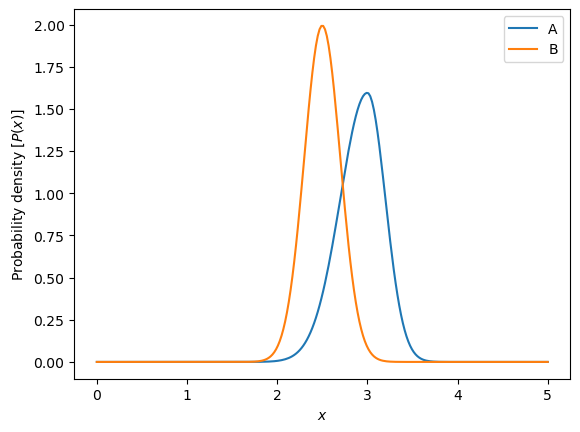

In [12]:
x = np.linspace(0,5,250)

plt.plot(x,A.pdf(x),label="A")
plt.plot(x,B.pdf(x),label="B")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Probability density [$P(x)$]")
plt.show()

Similarly, there is a `.cdf()` method as well.

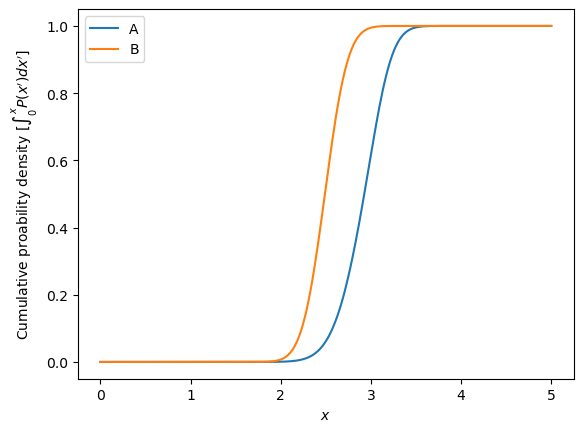

In [13]:
plt.plot(x,A.cdf(x),label="A")
plt.plot(x,B.cdf(x),label="B")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Cumulative proability density [$\int_0^x P(x') dx'$]")
plt.show()

### `a_u` objects as arrays

Because `a_u` is a subclass of `astropy.units.Quantity`, which is itself a subclass of `numpy.ndarray`, instances of `a_u` are technically NumPy arrays. In many cases, this is transparent. When initialized using a single nominal value, positive error, and negative error, `a_u` behaves like a regular number (i.e., `float`, `int`, etc.) for the most part (as we saw in the [Basic math](#basic-math) section). However, they can also be used as iterables, if multiple values are passed. This can be done in one of two ways:

1) passing separate arrays/iterables (of identical length/shape) to each of the parameters, interpreted to mean that the `i`-th element of `nominal` should have positive error `pos_err[i]` and negative error `neg_err[i]`
2) passing an iterable/array of already-initialized `a_u` objects

These two ways are both shown below (`C1` and `C2`, respectively).

Either way, iterating over the result will yield (for a 1D array) single (scalar) `a_u` instances.

In [14]:
C1 = a_u([3.0, 2.5], # nominal values
         [0.2, 0.2], # positive errors
         [0.3, 0.2]) # negative errors
C2 = a_u([A, B])
np.isclose(C1, C2)

array([ True,  True])

`[True, True]` indicates that each element of `C1` is equivalent (to within floating-point precision) to the respective element of `C2`.

However, we are not limited to 1-dimensional arrays. Below is an example of a 3&times;3 'matrix', where each element has an asymmetric uncertainty.

In [15]:
np.random.seed(42)
vals = 4*np.random.random(size=(3,3))
pos = np.random.random(size=(3,3))
neg = np.random.random(size=(3,3))
arr = a_u(vals, pos, neg, u.m) # method 1) above
arr

[[<1.49816047538945 (+0.7080725777960455, -0.43194501864211576) m>, <3.8028572256396647 (+0.020584494295802447, -0.2912291401980419) m>, <2.9279757672456204 (+0.9699098521619943, -0.6118528947223795) m>], [<2.3946339367881464 (+0.8324426408004217, -0.13949386065204183) m>, <0.6240745617697461 (+0.21233911067827616, -0.29214464853521815) m>, <0.6239780813448106 (+0.18182496720710062, -0.3663618432936917) m>], [<0.23233444867279784 (+0.18340450985343382, -0.45606998421703593) m>, <3.4647045830997407 (+0.3042422429595377, -0.7851759613930136) m>, <2.404460046972835 (+0.5247564316322378, -0.19967378215835974) m>]]

In [16]:
for row in arr:
    for elem in row:
        print(elem)

<1.49816047538945 (+0.7080725777960455, -0.43194501864211576) m>
<3.8028572256396647 (+0.020584494295802447, -0.2912291401980419) m>
<2.9279757672456204 (+0.9699098521619943, -0.6118528947223795) m>
<2.3946339367881464 (+0.8324426408004217, -0.13949386065204183) m>
<0.6240745617697461 (+0.21233911067827616, -0.29214464853521815) m>
<0.6239780813448106 (+0.18182496720710062, -0.3663618432936917) m>
<0.23233444867279784 (+0.18340450985343382, -0.45606998421703593) m>
<3.4647045830997407 (+0.3042422429595377, -0.7851759613930136) m>
<2.404460046972835 (+0.5247564316322378, -0.19967378215835974) m>


## Overloaded operators

We can compare these objects logically. Of course, $3.0>2.5$:

In [17]:
A>B

True

But we also have the ability to use `>>` and `<<` as "significantly greater than" and "significantly less than". The errors overlap (i.e. $3.0-0.4\ngtr2.5+0.3$), so the following is false.

In [18]:
A>>B

False

In [19]:
A>2.9

True

In [20]:
A>>2.9

False